# VGG imagenet 

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
import json
import skimage
import ipdb
%matplotlib inline

Using Theano backend.


# Data

In [32]:
path = 'data/dogscats/'

In [40]:
data = open('data/imagenet_class_index.json').read()
class_dict = json.loads(data)
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [41]:
classes[:5]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']

In [23]:
img = plt.imread('data/dogs-vs-cats/test/8595.jpg')
img.shape

(374, 500, 3)

# VGG architecture

In [2]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

        
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [3]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3, 1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

In [4]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

In [6]:
model = VGG_16()
model.load_weights('data/vgg16.h5')

/usr/local/lib/python2.7/site-packages/keras/layers/core.py:621: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


# Batch training

In [34]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator()

batch_size = 4

batch_train  = gen.flow_from_directory(
            'data/dogscats/sample/train/',
            target_size=(224,224), 
            class_mode='categorical',
            shuffle=True,
            batch_size=batch_size
        )

batch_valid  = gen.flow_from_directory(
            'data/dogscats/sample/valid',
            target_size=(224,224), 
            class_mode='categorical',
            shuffle=True,
            batch_size=batch_size
        )

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [35]:
# 1 batch of 4 pics
imgs,labels = next(batch_train)

(224, 224, 3)


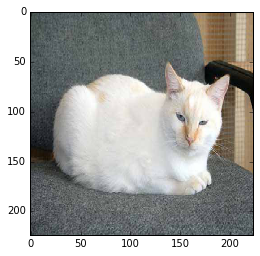

In [76]:
toto=imgs[0]
toto[0,:,:].shape
plt.imshow(toto[0,:,:],cmap='gray')
# yo = keras.preprocessing.image.img_to_array(tutu)
yo = np.array(keras.preprocessing.image.array_to_img(toto))
print yo.shape
plt.imshow(yo)

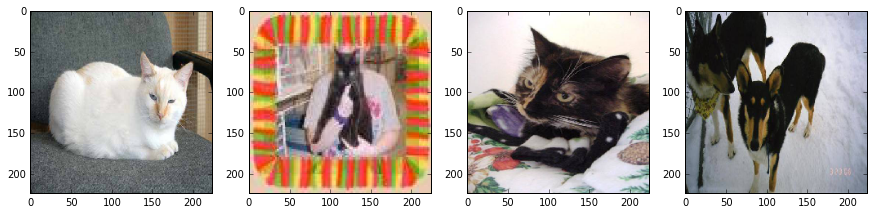

In [89]:
f, axes = plt.subplots(1,4,figsize=(15,15))
for idx, img in enumerate(imgs):
    axes[idx].imshow(keras.preprocessing.image.array_to_img(img),cmap='gray')


In [36]:
print imgs.shape, labels

(4, 3, 224, 224) [[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]]


In [42]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [43]:
pred_batch(imgs)

Shape: (4, 1000)
First 5 classes: [u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']
First 5 probabilities: [  7.20754144e-07   1.05264394e-06   9.72725866e-06   6.83951794e-06
   4.25309845e-05]

Predictions prob/class: 
  0.1889/lynx
  0.5114/hair_slide
  0.3788/tabby
  0.4503/dogsled
